#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q libtiff
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


В переменную PROJECT_DIR необходимо прописать путь к директории на Google Drive. Это пригодится при сохранении модели.

In [3]:
PROJECT_DIR = 'dev/neural_networks_task1/'

Константы, которые пригодятся в коде далее:

In [4]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')

Ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [5]:
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [6]:
from pathlib import Path
from libtiff import TIFF
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, хранящихся на Google Drive, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [7]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        if not Path(f'{name}.npz').exists():
            url = f'https://drive.google.com/uc?id={DATASETS_LINKS[name]}'
            output = f'{name}.npz'
            gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [8]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выборки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [9]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [29]:
class Model:

    def __init__(self):
       self.model = keras.models.Sequential([
            keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
            keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            keras.layers.MaxPooling2D((4, 4)),
            keras.layers.Dropout(0.2),

            keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.2),

            keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.2),

            keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Dropout(0.2),

            keras.layers.Flatten(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(9, activation='softmax'),
        ])

    def save(self, name: str):
        p = Path("/content/drive/MyDrive/" + PROJECT_DIR + name) 
        self.model.save(p)

    def load(self, name: str):
        name_to_id_dict = {
            'best': '106c19Pgnoe_JHRu6CeKX4OYXyubX_0kn'
        }
        url = f'https://drive.google.com/drive/folders/{name_to_id_dict[name]}'
        gdown.download_folder(url, quiet=True, output=name, use_cookies=False)
        self.model = keras.models.load_model(name)

    def train(self, dataset: Dataset):
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                           loss=keras.losses.SparseCategoricalCrossentropy(),
                           metrics=keras.metrics.SparseCategoricalAccuracy())
        
        # LBL1
        # Валидация модели на части обучающей выборки
        x_train, x_val, y_train, y_val = train_test_split(dataset.images, dataset.labels, test_size=0.2, random_state=1)
        
        # LBL2
        # Остановка обучения при потере точности на валидационной выборке
        early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',
                                                                patience=15,
                                                                restore_best_weights=True) 
        
        print(f'training started')
        self.history = self.model.fit(x_train, y_train,
                                     batch_size=64,
                                     epochs=70,
                                     validation_data=(x_val, y_val),
                                     shuffle=True,
                                     callbacks=[early_stopping_callback])
                                      
        print(f'training done')
      
    def summary(self):
        return self.model.summary()
      
    # LBL3
    # Вывод функции потерь и точности в процессе обучения
    def loss_and_accuracy_plots(self):
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Val'])

        plt.subplot(1,2,2)
        plt.plot(self.history.history['sparse_categorical_accuracy'])
        plt.plot(self.history.history['val_sparse_categorical_accuracy'])
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Val'])    

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        prediction = np.argmax(self.model(np.array([img])))
        return prediction


In [22]:
model = Model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 56, 56, 16)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 32)        4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 56, 32)        9248      
                                                      

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train' и 'test'.

In [12]:
d_train = Dataset('train')
d_test = Dataset('test')

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [23]:
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    model.load('best')

training started
Epoch 1/70
225/225 [==============================] - 45s 196ms/step - loss: 2.7289 - sparse_categorical_accuracy: 0.1187 - val_loss: 2.1649 - val_sparse_categorical_accuracy: 0.1989
Epoch 2/70
225/225 [==============================] - 44s 193ms/step - loss: 1.8627 - sparse_categorical_accuracy: 0.2579 - val_loss: 1.8182 - val_sparse_categorical_accuracy: 0.3028
Epoch 3/70
225/225 [==============================] - 44s 194ms/step - loss: 1.4827 - sparse_categorical_accuracy: 0.4210 - val_loss: 1.4432 - val_sparse_categorical_accuracy: 0.4278
Epoch 4/70
225/225 [==============================] - 44s 194ms/step - loss: 1.2621 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.2825 - val_sparse_categorical_accuracy: 0.4917
Epoch 5/70
225/225 [==============================] - 44s 194ms/step - loss: 1.1145 - sparse_categorical_accuracy: 0.5587 - val_loss: 1.1402 - val_sparse_categorical_accuracy: 0.5689
Epoch 6/70
225/225 [==============================] - 44s 194ms/step

Нарисуем графики функции потерь и точности.

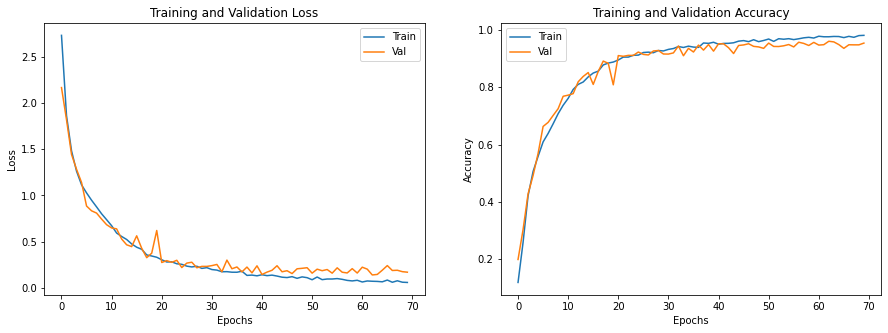

In [25]:
model.loss_and_accuracy_plots()

Пример тестирования модели на части набора данных:

In [ ]:
model = Model()
model.load('best')

In [26]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
#model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/450 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 0.9867:
	 balanced accuracy 0.9867:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [27]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9544:
	 balanced accuracy 0.9544:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [31]:
final_model = Model()
final_model.load('best')
d_test = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test)
Metrics.print_all(d_test.labels, pred, 'test_tiny')

Downloading...
From: https://drive.google.com/uc?id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 45.2MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test_tiny:
	 accuracy 0.9111:
	 balanced accuracy 0.9111:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()